In [123]:
import numpy as np
import matplotlib.pyplot as plt
from ssl_jax import load_replay_buffer_data
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 300

In [134]:
log_folder = 'logs/InvertedPendulum-v4/0712_1941'
log_folder = 'logs/InvertedPendulum-v4/0712_2046'
filename = f'{log_folder}/replay_buffer.npz'
states, actions, next_states, dones = load_replay_buffer_data(filename)
print('collected', states.shape[0], 'experiences')

collected 99000 experiences


In [135]:
for i in range(states.shape[0]):
    if np.all(states[i] == np.array([0.] * 4)):
        print('zero')

### Split data into variable length sequences

16382 temporal samples


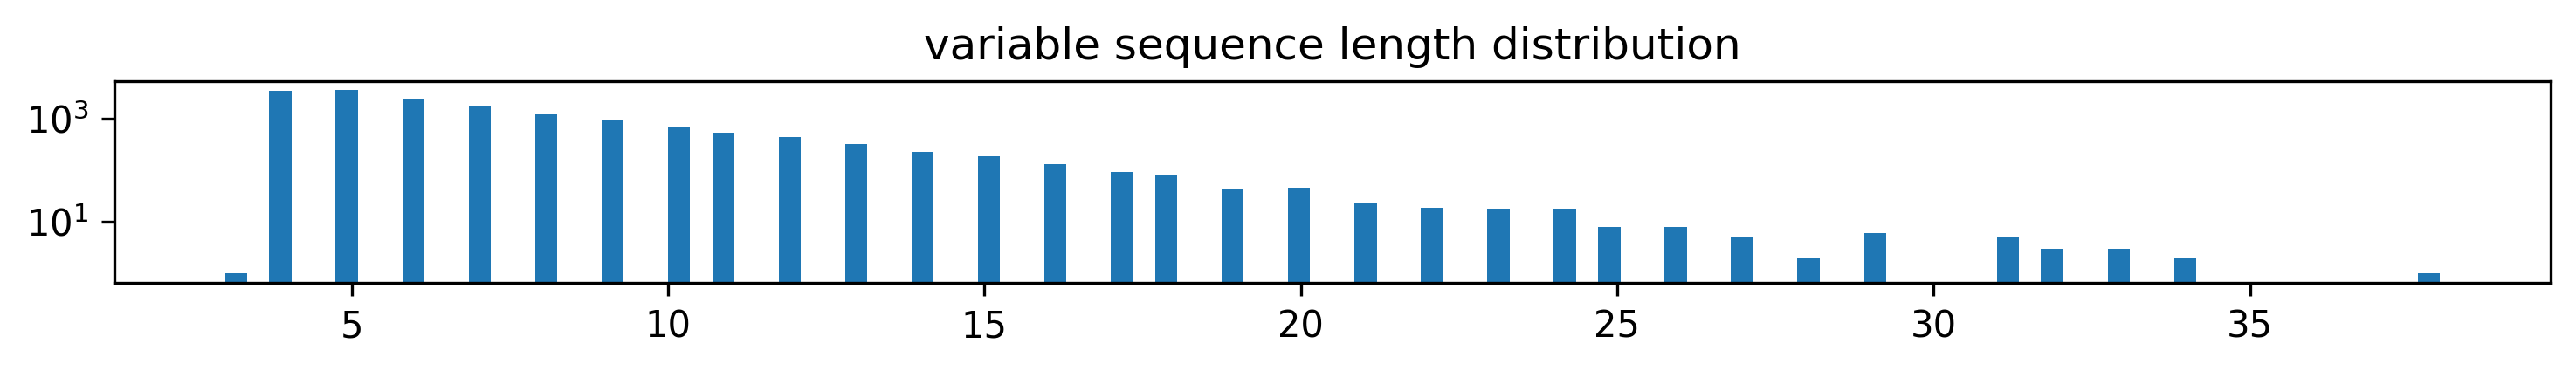

In [136]:
x = []
y = []
prev_idx = 0
for i in range(states.shape[0]):
    if dones[i, 0] == 1.:
        x.append(np.concatenate([states[prev_idx:i+1], actions[prev_idx:i+1]], axis=1))
        y.append(next_states[prev_idx:i+1])
        prev_idx = i
print(len(x), 'temporal samples')
plt.rcParams['figure.figsize'] = [12, 1]
plt.title('variable sequence length distribution')
plt.yscale('log')
plt.hist([x_.shape[0] for x_ in x], bins=100);

In [137]:
# store as hashmap
dict = {} # length: x: [], y: []
for idx in range(len(x)):
    length = x[idx].shape[0]
    if length not in dict:
        dict[length] = {'x': [], 'y': []}
    dict[length]['x'].append(x[idx])
    dict[length]['y'].append(y[idx])

In [138]:
MAX_LENGTH = max(list(dict.keys()))
MAX_LENGTH

38

In [139]:
x_padded = np.zeros((len(x), MAX_LENGTH, 5))
y_padded = np.zeros((len(x), MAX_LENGTH, 4))
lengths = np.zeros((len(x),), dtype=np.int32)
for idx in range(len(x)):
    x_padded[idx, :x[idx].shape[0], :] = x[idx]
    y_padded[idx, :y[idx].shape[0], :] = y[idx]
    lengths[idx] = x[idx].shape[0]

In [140]:
np.save(f'{log_folder}/x_padded.npy', x_padded)
np.save(f'{log_folder}/y_padded.npy', y_padded)
np.save(f'{log_folder}/lengths.npy', lengths)

## Plots

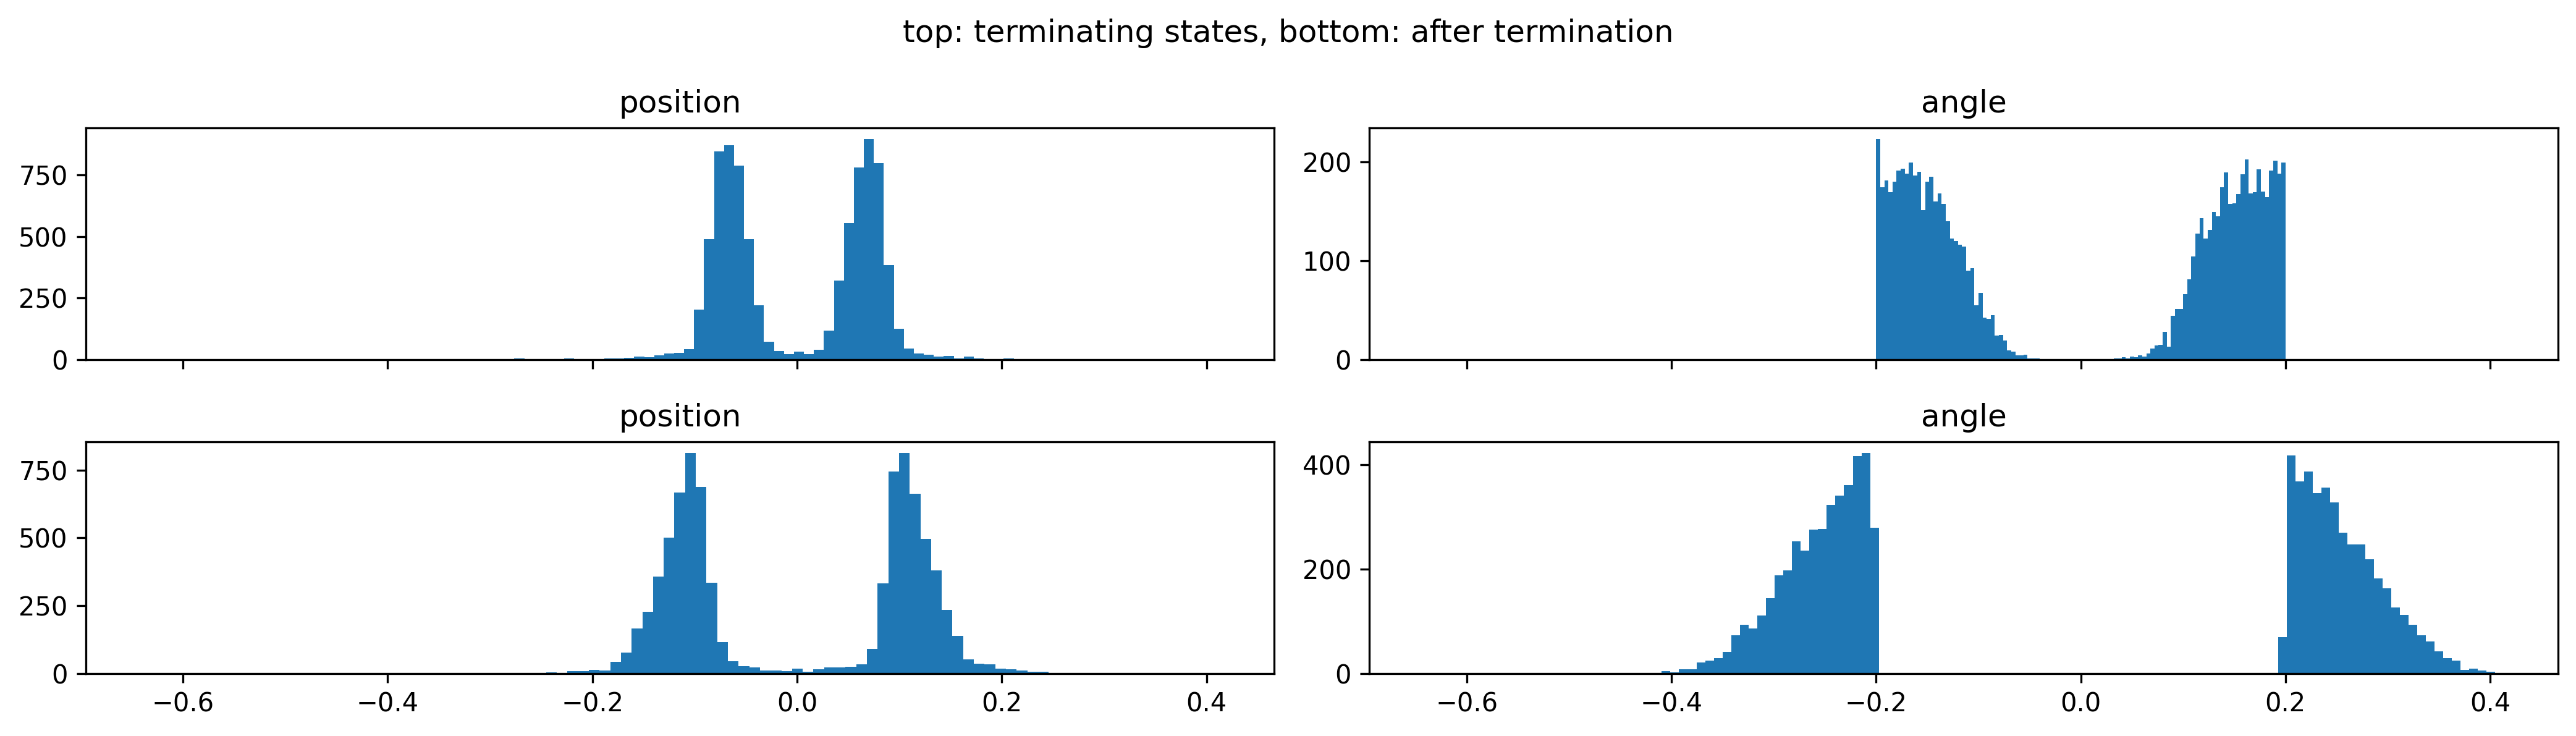

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(14, 4), dpi=300, sharex=True)
axs = axs.flatten()
fig.suptitle('top: terminating states, bottom: after termination')
titles = 'position angle'.split(' ')
states_ = states[dones[:, 0] == 1.]
for i in range(2):
    axs[i].set_title(titles[i])
    axs[i].hist(states_[:, i], bins=100)
states_ = next_states[dones[:, 0] == 1.]
for i in range(2):
    axs[i+2].set_title(titles[i])
    axs[i+2].hist(states_[:, i], bins=100)
plt.tight_layout();

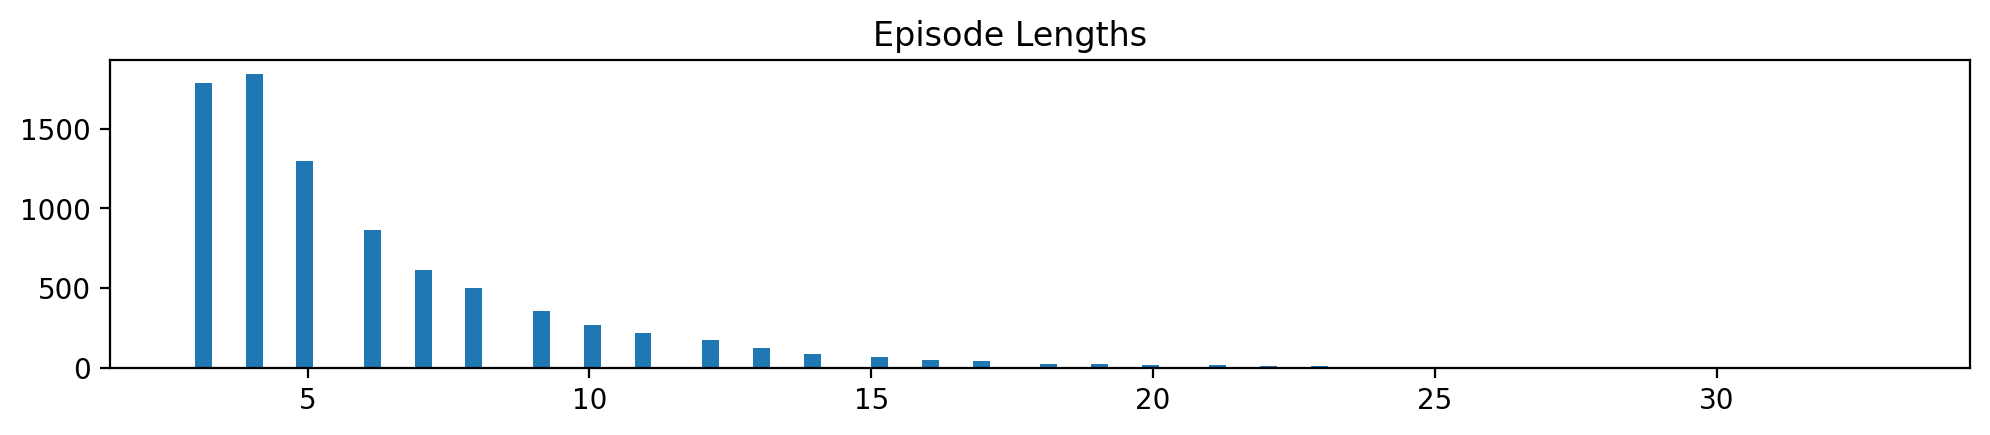

In [37]:
done_idx = np.where(dones[:, 0] == 1.)[0]
np.diff(done_idx)
fig, ax = plt.subplots(figsize=(12, 2), dpi=200)
fig.suptitle('Episode Lengths')
ax.hist(np.diff(done_idx), bins=100);

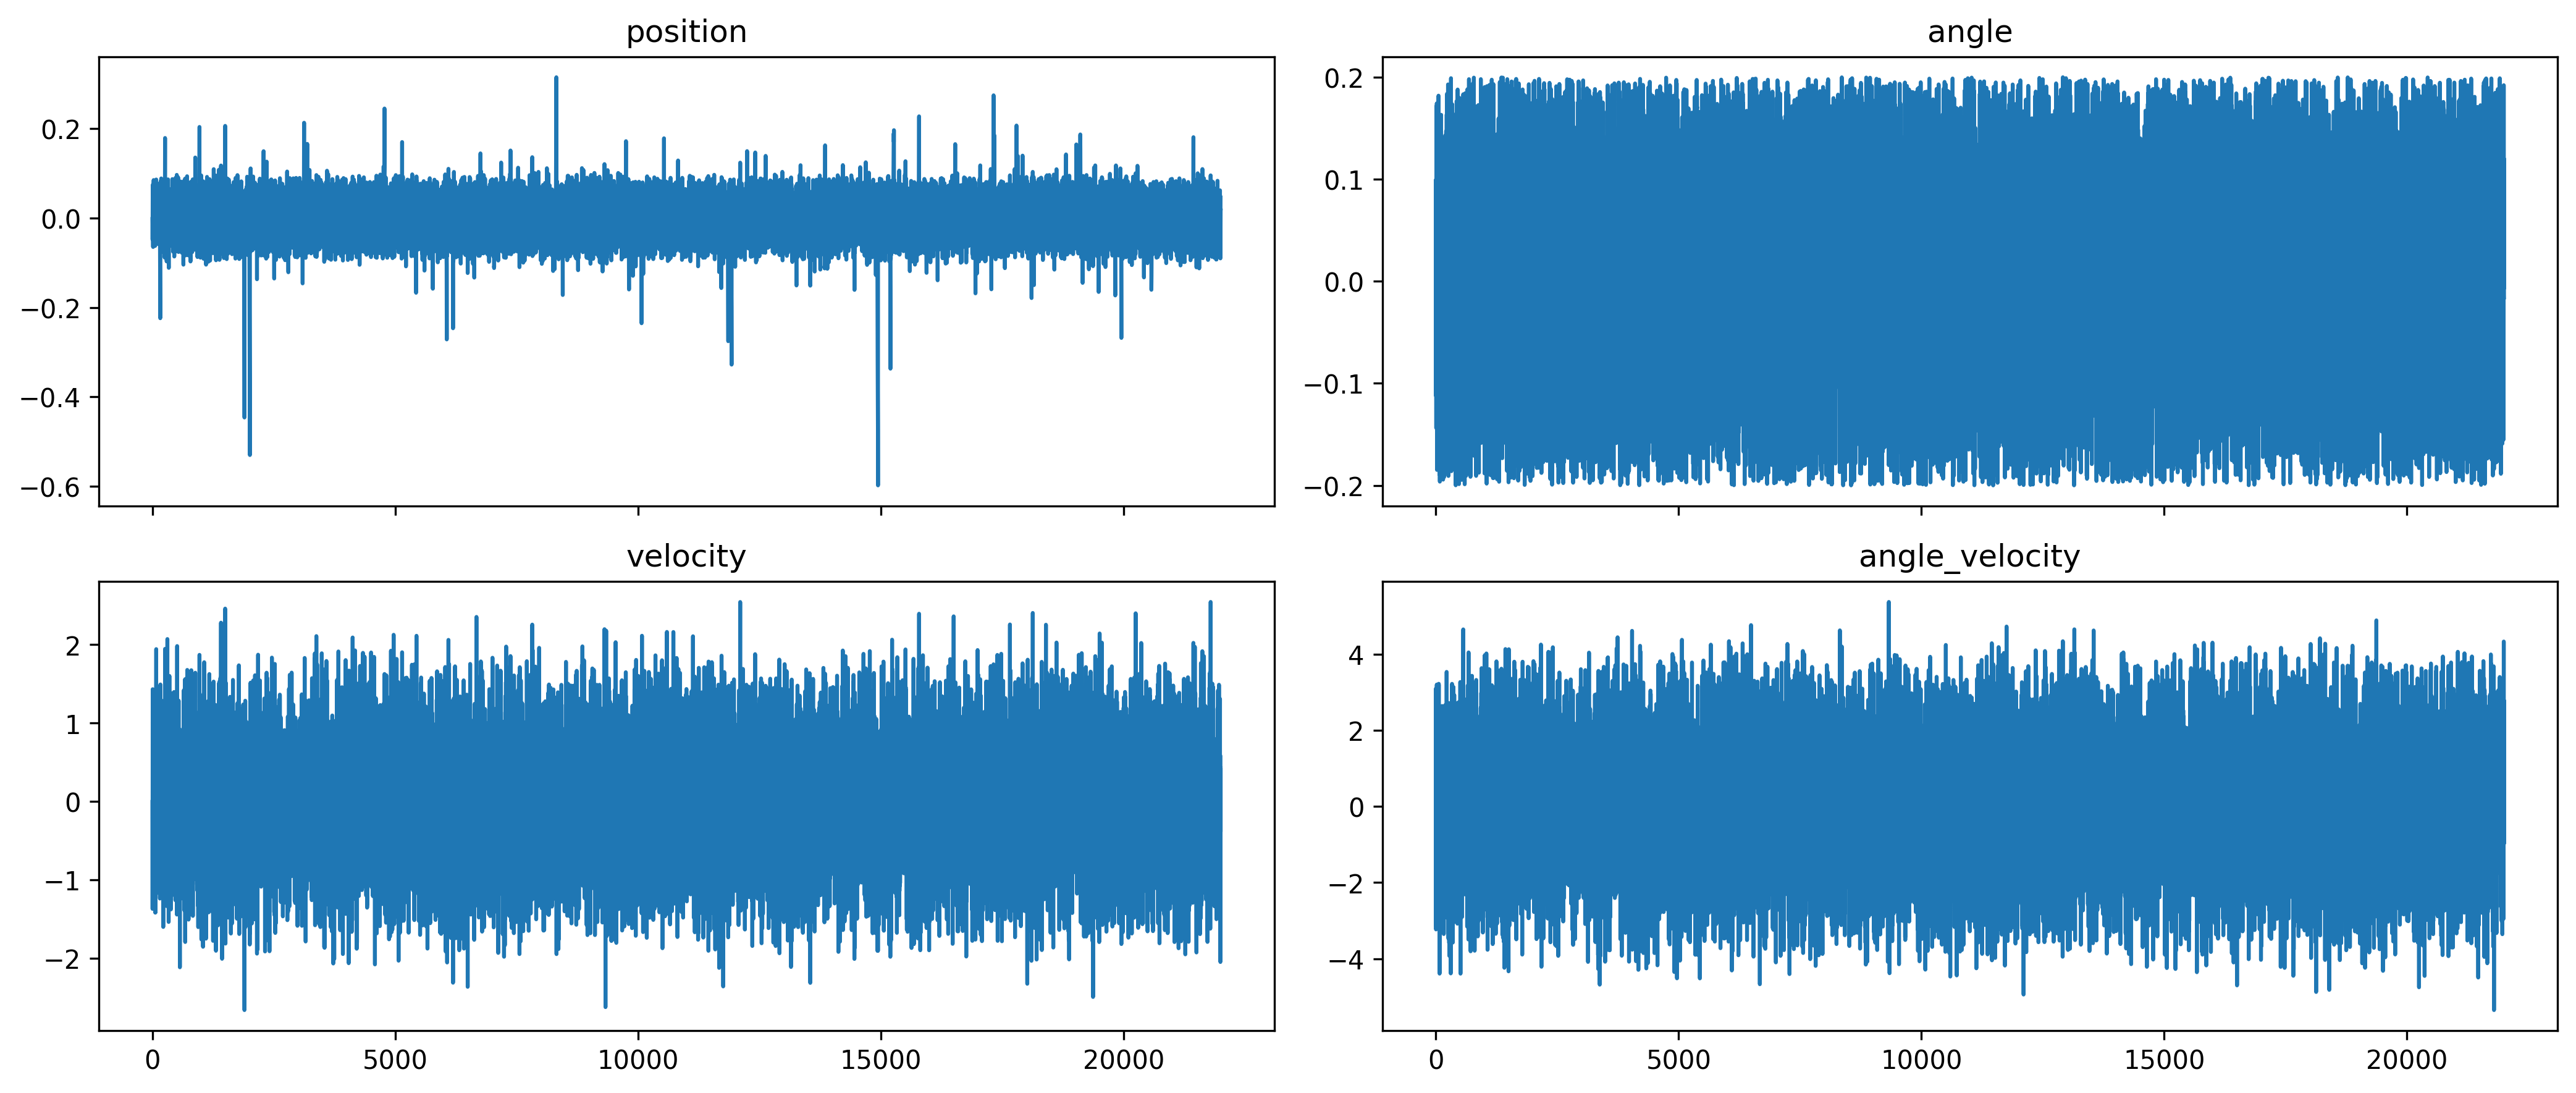

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(14, 6), dpi=300, sharex=True)
axs = axs.flatten()
titles = 'position angle velocity angle_velocity'.split(' ')
for i in range(4):
    axs[i].set_title(titles[i])
    axs[i].plot(states[:, i])
plt.tight_layout();

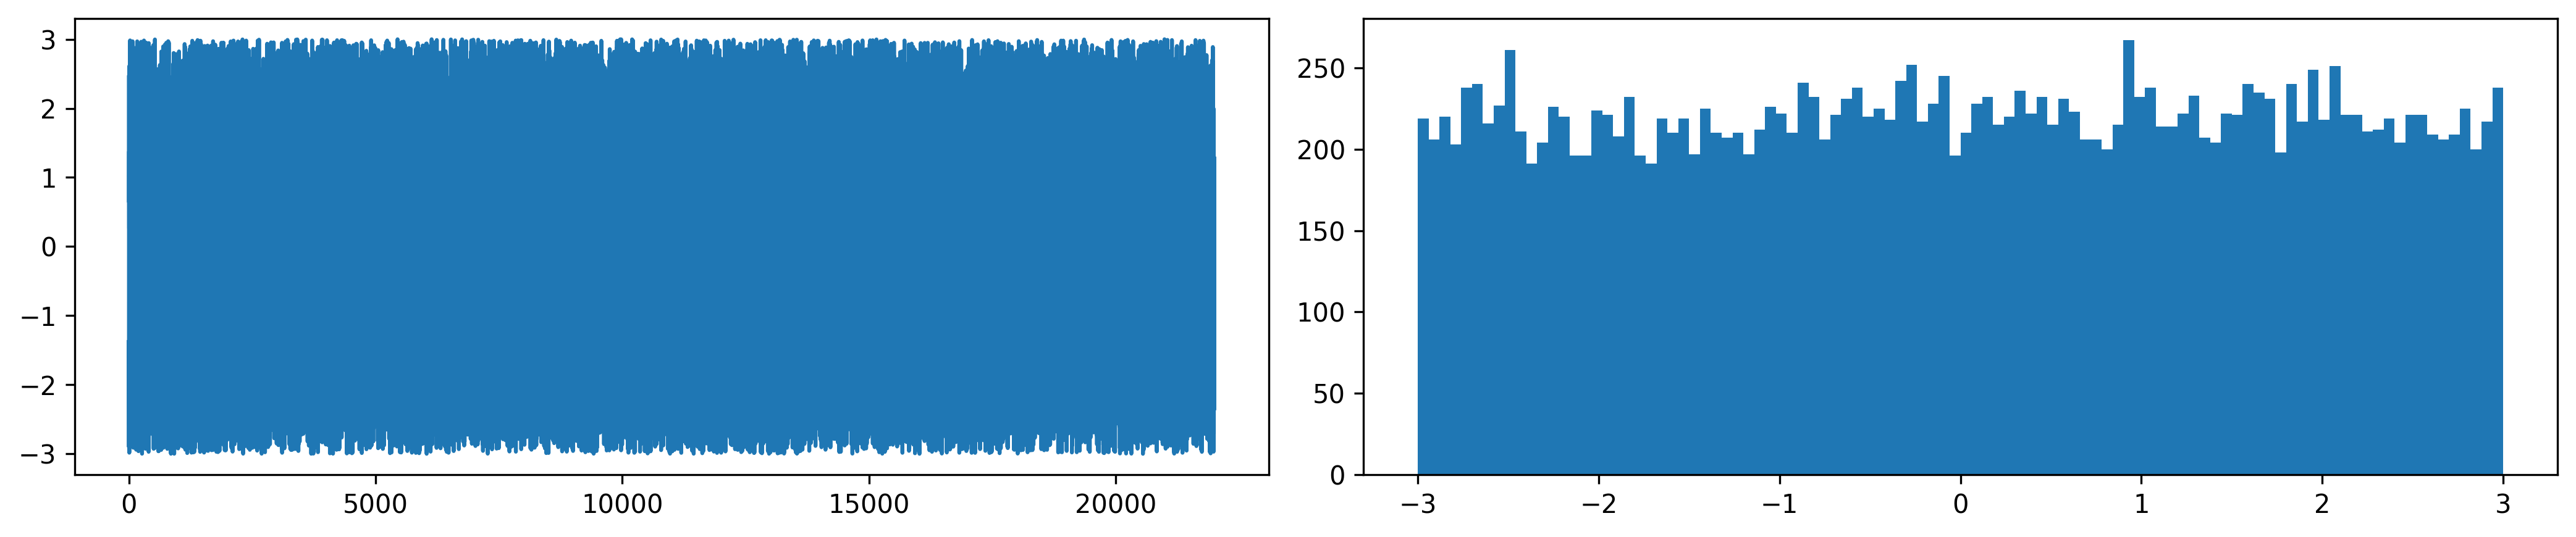

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(14, 3), dpi=300)
axs[0].plot(actions)
axs[1].hist(actions, bins=100)
plt.tight_layout();